# Multi-Class Age Group Classification Using Logistic Regression

This notebook develops a logistic regression classifier to differentiate between three age groups in the BNC2014 corpus:
- **Young**: Speakers aged 0-29 years
- **Middle**: Speakers aged 30-59 years
- **Senior**: Speakers aged 60+ years

The analysis follows these steps:
1. Load the BNC2014 corpus data and speaker metadata
2. Process the corpus to extract speaker-level features
3. Create a multi-class age classification
4. Split data into training (80%) and test (20%) sets
5. Train a multi-class logistic regression model 
6. Evaluate model performance on the test set
7. Analyze the most informative features

This analysis will help us understand the linguistic differences between multiple age groups and what features are most predictive of a speaker's age group.

In [15]:
# Import required libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import lxml.etree as ET
from wordcloud import WordCloud

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load BNC2014 Corpus Data and Speaker Metadata

First, let's load the corpus data and speaker metadata. This includes speaker demographic information and the text data associated with each speaker.

In [16]:
# Set the path to the dataset
path = 'Dataset'  
dir_corpus = os.path.join(path, 'spoken', 'tagged')
dir_meta = os.path.join(path, 'spoken', 'metadata')

# Load speaker metadata
fields_s = pd.read_csv(
    os.path.join(dir_meta, 'metadata-fields-speaker.txt'),
    sep='\t', skiprows=1, index_col=0
)

# Load the speaker metadata
df_speakers_meta = pd.read_csv(
    os.path.join(dir_meta, 'bnc2014spoken-speakerdata.tsv'),
    sep='\t', names=fields_s['XML tag'], index_col=0
)

print(f"Loaded metadata for {len(df_speakers_meta)} speakers")
print("\nSample of speaker metadata:")
print(df_speakers_meta.head())

Loaded metadata for 671 speakers

Sample of speaker metadata:
      exactage  age1994 agerange gender      nat  \
S0001       32    25_34    30_39      F  British   
S0002      NaN  Unknown    19_29      F  British   
S0003      NaN  Unknown    19_29      F  British   
S0004      NaN  Unknown    30_39      M  British   
S0005      NaN   60plus    80_89      F  British   

                               birthplace birthcountry       l1 lingorig  \
S0001             Wordsley, West Midlands      England  English  England   
S0002                          Birmingham      England  English  England   
S0003  Royal Leamington Spa, Warwickshire      England  English  England   
S0004                                 NaN      Germany  English  England   
S0005                          Birmingham      England  English  England   

          dialect_rep  ...   dialect_l2   dialect_l3   dialect_l4  \
S0001  None indicated  ...  unspecified  unspecified  unspecified   
S0002        Midlands  ...    

Age range distribution:
agerange
0_10         7
11_18       42
19_29      250
30_39       89
40_49       76
50_59       77
60_69       65
70_79       33
80_89       19
90_99        4
Unknown      9
Name: count, dtype: int64


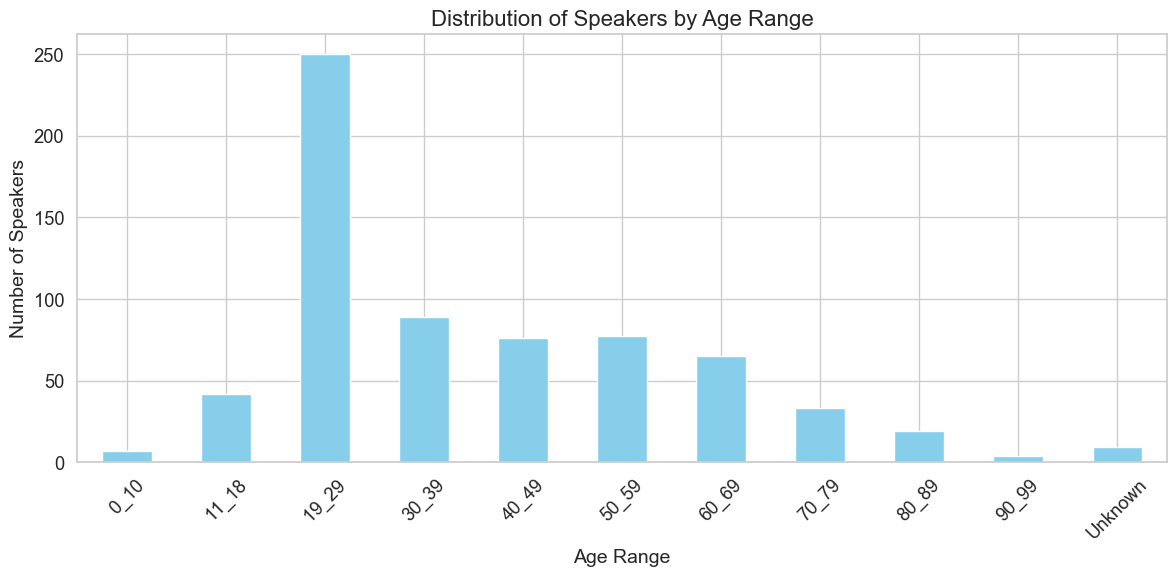

In [17]:
# Check the distribution of age ranges in the metadata
print("Age range distribution:")
age_counts = df_speakers_meta['agerange'].value_counts().sort_index()
print(age_counts)

# Visualize age distribution
plt.figure(figsize=(12, 6))
age_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Speakers by Age Range', fontsize=16)
plt.xlabel('Age Range', fontsize=14)
plt.ylabel('Number of Speakers', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Create Multi-Class Age Groups

We'll divide speakers into three age categories:
- **Young**: Speakers aged 0-29 years (combining age ranges 0-18 and 19-29)
- **Middle**: Speakers aged 30-59 years
- **Senior**: Speakers aged 60+ years

Distribution of speakers by age group classification:
age_group
Young     388
Middle    153
Senior    121
Name: count, dtype: int64
Young: 58.6%
Middle: 23.1%
Senior: 18.3%


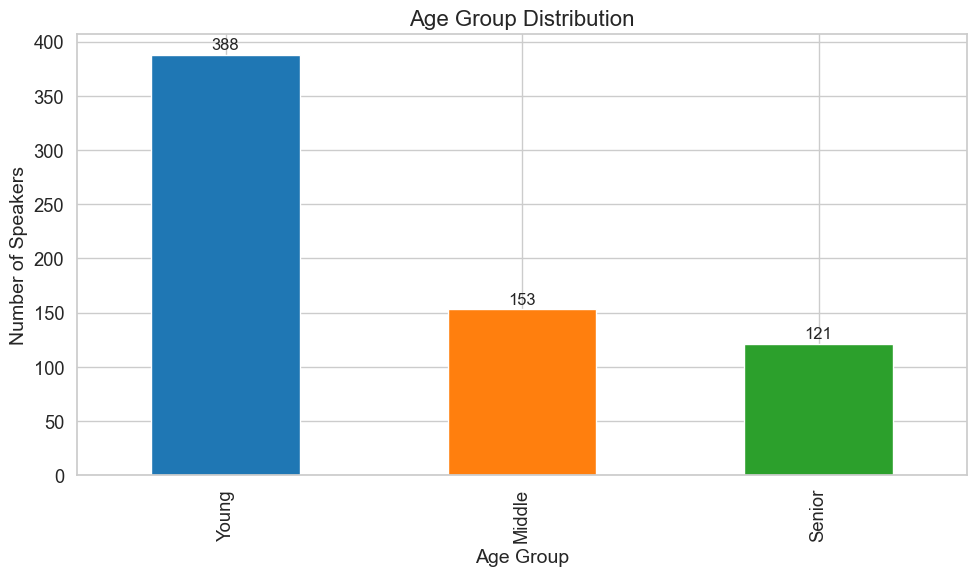


Example speakers in 'Young' group:
      gender agerange age_group      edqual
S0001      F    30_39     Young  5_postgrad
S0002      F    19_29     Young  5_postgrad
S0003      F    19_29     Young  4_graduate

Example speakers in 'Middle' group:
      gender agerange age_group       edqual
S0023      M    40_49    Middle  3_sixthform
S0027      M    40_49    Middle  3_sixthform
S0030      F    40_49    Middle   5_postgrad

Example speakers in 'Senior' group:
      gender agerange age_group       edqual
S0005      F    80_89    Senior  2_secondary
S0006      M    80_89    Senior  3_sixthform
S0008      M    60_69    Senior   4_graduate


In [18]:
# Function to map BNC age ranges to multi-class categories
def map_to_multiclass_age(age_range):
    """
    Map BNC age ranges to three age categories:
    Young (0-29), Middle (30-59), and Senior (60+)
    
    Parameters:
    -----------
    age_range : str
        Age range from BNC metadata (e.g., '0_18', '19-29', '30_59', '60_plus')
        
    Returns:
    --------
    str
        'Young', 'Middle', or 'Senior' classification
    """
    if pd.isna(age_range) or age_range == 'Unknown':
        return np.nan
    
    # Handle different formats in the age range field
    try:
        # Extract bounds of the age range
        if '_' in str(age_range):
            parts = str(age_range).split('_')
        elif '-' in str(age_range):
            parts = str(age_range).split('-')
        else:
            # Skip unknown formats
            return np.nan
        
        # Get lower and upper bounds
        lower = int(parts[0])
        
        # Handle special case for '60_plus'
        if parts[1] == 'plus':
            upper = 100  # Arbitrarily high for '60_plus'
        else:
            upper = int(parts[1])
        
        # Classify into three age groups
        if upper <= 39:
            return "Young"
        elif upper <= 59:
            return "Middle"
        else:
            return "Senior"
    except Exception as e:
        # Return NaN for any errors
        return np.nan

# Apply the multi-class age classification to speaker metadata
df_speakers_meta['age_group'] = df_speakers_meta['agerange'].apply(map_to_multiclass_age)

# Display the counts for each age group
age_group_counts = df_speakers_meta['age_group'].value_counts()
print("Distribution of speakers by age group classification:")
print(age_group_counts)

# Calculate percentages
percentages = 100 * age_group_counts / age_group_counts.sum()
for group, pct in percentages.items():
    print(f"{group}: {pct:.1f}%")

# Visualize the age group distribution
plt.figure(figsize=(10, 6))
ax = age_group_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Age Group Distribution', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Speakers', fontsize=14)

# Add count labels on top of bars
for i, count in enumerate(age_group_counts):
    ax.text(i, count + 5, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Show examples of speakers in each age group
for group in ['Young', 'Middle', 'Senior']:
    print(f"\nExample speakers in '{group}' group:")
    examples = df_speakers_meta[df_speakers_meta['age_group'] == group].head(3)
    print(examples[['gender', 'agerange', 'age_group', 'edqual']])

## 3. Load and Process Corpus Text Data

Now, we'll load the corpus text data and extract features for each speaker, including:
- Word usage patterns
- Lexical diversity
- Part-of-speech usage
- Sentence structure features

In [ ]:
# Process tagged corpus files to extract word and linguistic feature data
# Process all available files in the corpus
corpus_files = sorted(os.listdir(dir_corpus))
file_count_total = len(corpus_files)
print(f"Found {file_count_total} files in the corpus directory")

tagged_rows = []
try:
    # Load all corpus files
    for file_count, fname in enumerate(corpus_files):
        # Print progress every 5 files
        if file_count % 5 == 0:
            print(f"Processing file {file_count+1}/{file_count_total}: {fname}")
            
        fpath = os.path.join(dir_corpus, fname)
        xml = ET.parse(fpath)
        root = xml.getroot()
        text_id = root.get('id')
        
        for u in root.findall('.//u'):
            utt_id = u.get('n')
            spk = u.get('who')
            for w in u.findall('w'):
                tagged_rows.append({
                    'text_id': text_id,
                    'utterance_id': utt_id,
                    'speaker_id': spk,
                    'word': w.text,
                    'lemma': w.get('lemma'),
                    'pos': w.get('pos'),
                    'class': w.get('class'),
                    'usas': w.get('usas'),
                })
    
    # Create a DataFrame from the extracted data
    df_tagged = pd.DataFrame(tagged_rows)
    
    print(f"\nLoaded {len(df_tagged)} word tokens from {file_count_total} files")
    print(f"Found {df_tagged['speaker_id'].nunique()} unique speakers in the processed data")
    
except Exception as e:
    print(f"Error loading corpus data: {e}")

Found 1251 files in the corpus directory
Processing file 1/1251: S23A-tgd.xml
Processing file 6/1251: S26N-tgd.xml
Processing file 11/1251: S2A5-tgd.xml
Processing file 16/1251: S2CY-tgd.xml
Processing file 21/1251: S2FT-tgd.xml
Processing file 26/1251: S2K6-tgd.xml
Processing file 31/1251: S2NQ-tgd.xml
Processing file 36/1251: S2T6-tgd.xml
Processing file 41/1251: S2UT-tgd.xml
Processing file 46/1251: S2YK-tgd.xml
Processing file 51/1251: S33B-tgd.xml
Processing file 56/1251: S35U-tgd.xml
Processing file 61/1251: S37K-tgd.xml
Processing file 66/1251: S38V-tgd.xml
Processing file 71/1251: S3C6-tgd.xml
Processing file 76/1251: S3JF-tgd.xml
Processing file 81/1251: S3MW-tgd.xml
Processing file 86/1251: S3RZ-tgd.xml
Processing file 91/1251: S3TZ-tgd.xml
Processing file 96/1251: S3YZ-tgd.xml
Processing file 101/1251: S457-tgd.xml
Processing file 106/1251: S47C-tgd.xml
Processing file 111/1251: S4C2-tgd.xml
Processing file 116/1251: S4K7-tgd.xml
Processing file 121/1251: S4MV-tgd.xml
Proces

In [ ]:
# Explore the corpus data
print("Sample of word-level data:")
print(df_tagged.head())

# Count of speakers with valid age data
valid_age_speakers = set(df_speakers_meta[~df_speakers_meta['age_group'].isna()].index)
tagged_speakers = set(df_tagged['speaker_id'].unique())
valid_speakers = valid_age_speakers.intersection(tagged_speakers)

print(f"\nOf {len(tagged_speakers)} speakers in the corpus data, {len(valid_speakers)} have valid age data")

# Filter to only include speakers with valid age data
df_tagged_valid = df_tagged[df_tagged['speaker_id'].isin(valid_speakers)]
print(f"Filtered corpus data contains {len(df_tagged_valid)} word tokens from {len(valid_speakers)} speakers")

Sample of word-level data:
  text_id utterance_id speaker_id   word lemma   pos  class  usas
0    S23A            1      S0094  words  word   NN2  SUBST    Q3
1    S23A            2      S0095     it    it  PPH1   PRON    Z8
2    S23A            2      S0095     's    be   VBZ   VERB    A3
3    S23A            2      S0095      a     a   AT1    ART    Z5
4    S23A            2      S0095  games  game   NN2  SUBST  K5:1

Of 671 speakers in the corpus data, 662 have valid age data
Filtered corpus data contains 11181155 word tokens from 662 speakers


## 4. Feature Engineering

Now let's create features for each speaker that we'll use for classification. We'll extract:
1. Word usage patterns (bag of words)
2. Part-of-speech distribution
3. Lexical diversity measures
4. Other linguistic features

In [ ]:
# Create speaker-level features
def create_speaker_features(df_tagged, df_speakers_meta):
    """
    Create a dataframe of speaker-level features for classification
    
    Parameters:
    -----------
    df_tagged : pd.DataFrame
        DataFrame with word-level corpus data
    df_speakers_meta : pd.DataFrame
        DataFrame with speaker metadata
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with speaker-level features
    """
    # Dictionary to store features for each speaker
    speaker_features = {}
    
    # Group by speaker_id
    for speaker_id, speaker_data in df_tagged.groupby('speaker_id'):
        if speaker_id not in df_speakers_meta.index:
            continue
            
        # Extract words and texts for this speaker
        words = speaker_data['word'].tolist()
        lemmas = speaker_data['lemma'].fillna('').tolist()
        pos_tags = speaker_data['pos'].fillna('').tolist()
        word_classes = speaker_data['class'].fillna('').tolist()
        
        # Skip speakers with too few words (< 50)
        if len(words) < 50:
            continue
            
        # Dictionary for this speaker's features
        features = {}
        
        # 1. Basic counts
        features['total_words'] = len(words)
        features['unique_words'] = len(set([w.lower() for w in words if w]))
        features['unique_lemmas'] = len(set([l.lower() for l in lemmas if l]))
        
        # 2. Lexical diversity (type-token ratio)
        features['lexical_diversity'] = features['unique_words'] / features['total_words']
        features['lemma_diversity'] = features['unique_lemmas'] / features['total_words']
        
        # 3. Part-of-speech distributions
        pos_counter = Counter(pos_tags)
        total_pos = sum(pos_counter.values())
        
        # Add normalized POS features (as percentages)
        for pos, count in pos_counter.most_common():
            if pos:  # Skip empty POS tags
                features[f'pos_{pos}'] = count / total_pos
                
        # 4. Word class distributions
        class_counter = Counter(word_classes)
        total_classes = sum(class_counter.values())
        
        # Add normalized word class features
        for wclass, count in class_counter.most_common():
            if wclass:  # Skip empty class tags
                features[f'class_{wclass}'] = count / total_classes
        
        # 5. Calculate average word length
        word_lengths = [len(w) for w in words if w]
        features['avg_word_length'] = sum(word_lengths) / len(word_lengths) if word_lengths else 0
        
        # 6. Count specific linguistic markers
        
        # Filler words and discourse markers
        filler_words = ['um', 'uh', 'er', 'erm', 'like', 'you know', 'i mean', 'well', 'so']
        filler_count = sum(1 for w in words if w and w.lower() in filler_words)
        features['filler_ratio'] = filler_count / features['total_words']
        
        # Store features for this speaker
        speaker_features[speaker_id] = features
    
    # Create DataFrame from features dictionary
    features_df = pd.DataFrame.from_dict(speaker_features, orient='index')
    
    # Add age group from metadata
    features_df = features_df.join(
        df_speakers_meta[['age_group', 'gender', 'edqual']], 
        how='left'
    )
    
    # Drop rows with missing age_group
    features_df = features_df.dropna(subset=['age_group'])
    
    return features_df

# Create speaker features dataframe
speakers_df = create_speaker_features(df_tagged_valid, df_speakers_meta)

print(f"Created feature dataframe with {len(speakers_df)} speakers")
print(f"Feature dataframe has {speakers_df.shape[1]} columns")

# Show some sample speakers with their features
print("\nSample of speaker features:")
print(speakers_df.head())

# See the distribution of age groups in the feature dataset
print("\nDistribution of age groups in feature dataset:")
age_distribution = speakers_df['age_group'].value_counts()
print(age_distribution)

# Calculate percentages
age_percentages = 100 * age_distribution / age_distribution.sum()
for group, pct in age_percentages.items():
    print(f"{group}: {pct:.1f}%")

Created feature dataframe with 658 speakers
Feature dataframe has 274 columns

Sample of speaker features:
       total_words  unique_words  unique_lemmas  lexical_diversity  \
S0001         2890           673            588           0.232872   
S0002         8481          1161            978           0.136894   
S0003         1876           406            360           0.216418   
S0004         3626           888            767           0.244898   
S0005         1438           346            303           0.240612   

       lemma_diversity   pos_NN1    pos_RR    pos_UH    pos_JJ    pos_II  ...  \
S0001         0.203460  0.087543  0.067128  0.056401  0.048789  0.041176  ...   
S0002         0.115317  0.071925  0.065676  0.035373  0.043391  0.043155  ...   
S0003         0.191898  0.073028  0.042111  0.055437  0.038913  0.049041  ...   
S0004         0.211528  0.106729  0.044677  0.033646  0.041368  0.048538  ...   
S0005         0.210709  0.073018  0.033380  0.054937  0.031989  0.0

In [ ]:
# Create a text corpus for each speaker for bag-of-words features
# Combine all words from each speaker into a single document
speaker_texts = {}

for speaker_id, speaker_data in df_tagged_valid.groupby('speaker_id'):
    if speaker_id in speakers_df.index:
        words = speaker_data['lemma'].fillna('').tolist()
        # Convert to lowercase and join with spaces
        speaker_texts[speaker_id] = ' '.join([w.lower() for w in words if w])

# Create a Series with speaker_id as index and text as values
speaker_corpus = pd.Series(speaker_texts)

# Display the first few speaker texts
print(f"Created text corpus for {len(speaker_corpus)} speakers")
print("\nSample speaker texts:")
for speaker_id, text in list(speaker_corpus.items())[:2]:
    print(f"\nSpeaker {speaker_id}:")
    print(text[:200] + "...")  # Show first 200 characters

Created text corpus for 658 speakers

Sample speaker texts:

Speaker S0001:
mm sit around drinking tea watch small child play with toy there be some of that mm that be your godmother 's dog be not it punc she be like stay at --anonnamem 's parent over christmas as well and er...

Speaker S0002:
yes unfortunately i mean fortunately er oh do i say that punc yes it be just a lesser hovel two flatmate but they be quite quiet they be third year undergrad so they be about to finish and they have g...


## 5. Prepare Data for Multi-Class Classification

Now we'll prepare our data for the multi-class logistic regression classifier. We'll:
1. Encode the target variable
2. Split the data into training and test sets (80% train, 20% test)
3. Create a TF-IDF vectorizer for text features
4. Scale numerical features

In [ ]:
# Encode the target variable (age_group) using LabelEncoder
label_encoder = LabelEncoder()
speakers_df['age_label'] = label_encoder.fit_transform(speakers_df['age_group'])

# Verify encoding
print("Multi-class age encoding:")
encoding_map = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(encoding_map)
print(speakers_df[['age_group', 'age_label']].drop_duplicates())

# Get features and target
X_features = speakers_df.drop(['age_group', 'age_label', 'gender', 'edqual'], axis=1)
y = speakers_df['age_label']

# Check for and handle NaN values
print(f"Features with NaN values: {X_features.isna().any().sum()} out of {X_features.shape[1]}")
if X_features.isna().any().any():
    print("Imputing missing values...")
    # Use simple imputation with mean strategy
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_features_imputed = pd.DataFrame(
        imputer.fit_transform(X_features),
        columns=X_features.columns,
        index=X_features.index
    )
    print("Imputation complete.")
else:
    X_features_imputed = X_features

# Get the corpus for the speakers in our feature set
corpus = speaker_corpus[X_features_imputed.index]

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test, corpus_train, corpus_test = train_test_split(
    X_features_imputed, y, corpus, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"Training set: {len(X_train)} speakers")
print(f"Test set: {len(X_test)} speakers")

# Verify class distribution in train and test sets
print("\nClass distribution in training set:")
train_dist = pd.Series(y_train).map(dict((v,k) for k,v in encoding_map.items())).value_counts()
print(train_dist)
print((100 * train_dist / train_dist.sum()).round(1))

print("\nClass distribution in test set:")
test_dist = pd.Series(y_test).map(dict((v,k) for k,v in encoding_map.items())).value_counts()
print(test_dist)
print((100 * test_dist / test_dist.sum()).round(1))

Multi-class age encoding:
{'Middle': 0, 'Senior': 1, 'Young': 2}
      age_group  age_label
S0001    Middle          0
S0002     Young          2
S0005    Senior          1
Features with NaN values: 243 out of 271
Imputing missing values...
Imputation complete.
Training set: 526 speakers
Test set: 132 speakers

Class distribution in training set:
age_label
Young     236
Middle    193
Senior     97
Name: count, dtype: int64
age_label
Young     44.9
Middle    36.7
Senior    18.4
Name: count, dtype: float64

Class distribution in test set:
age_label
Young     60
Middle    48
Senior    24
Name: count, dtype: int64
age_label
Young     45.5
Middle    36.4
Senior    18.2
Name: count, dtype: float64


## 6. Train Multi-Class Logistic Regression Model

We'll now train a multi-class logistic regression model using both:
1. Linguistic features from our feature engineering
2. TF-IDF features from the speaker text corpus

In [ ]:
# Create TF-IDF vectorizer for the text corpus
tfidf = TfidfVectorizer(
    max_features=300,  # Use top 300 features
    min_df=5,          # Minimum document frequency
    max_df=0.7,        # Maximum document frequency (remove very common words)
    stop_words='english' # Remove English stopwords
)

# Fit and transform the training corpus
X_train_tfidf = tfidf.fit_transform(corpus_train)

# Transform the test corpus
X_test_tfidf = tfidf.transform(corpus_test)

print(f"TF-IDF matrix shape for training data: {X_train_tfidf.shape}")
print(f"TF-IDF matrix shape for test data: {X_test_tfidf.shape}")

# Select most important features from our engineered features
# This helps prevent overfitting by using too many features
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 20 features based on ANOVA F-value
selector = SelectKBest(f_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the names of the selected features
selected_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_indices]

print("\nTop 20 selected engineered features:")
print(selected_features.tolist())

# Scale the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Combine TF-IDF features with selected engineered features
from scipy.sparse import hstack

X_train_combined = hstack([X_train_tfidf, X_train_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_scaled])

print(f"\nCombined feature matrix shape for training: {X_train_combined.shape}")
print(f"Combined feature matrix shape for testing: {X_test_combined.shape}")

TF-IDF matrix shape for training data: (526, 300)
TF-IDF matrix shape for test data: (132, 300)

Top 20 selected engineered features:
['pos_RR', 'pos_CC', 'pos_VBZ', 'pos_PPIS1', 'pos_AT', 'pos_VVN', 'pos_VVD', 'pos_PPHS2', 'pos_VHD', 'pos_RL', 'pos_VBDR', 'pos_EX', 'pos_VBM', 'pos_VVGK', 'pos_RRQ', 'pos_VMK', 'class_ADV', 'class_CONJ', 'class_ART', 'filler_ratio']

Combined feature matrix shape for training: (526, 320)
Combined feature matrix shape for testing: (132, 320)


In [ ]:
# Train a multi-class logistic regression model
# We'll use 'multinomial' option with 'saga' solver for multi-class classification
multi_log_reg = LogisticRegression(
    C=1.0,               # Regularization strength (inverse)
    penalty='l2',        # L2 regularization
    solver='saga',       # Solver that works well for multi-class
    multi_class='multinomial',  # Multinomial loss for multi-class
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1            # Use all available cores
)

# Train the model
multi_log_reg.fit(X_train_combined, y_train)

# Get predictions
y_pred = multi_log_reg.predict(X_test_combined)
y_pred_proba = multi_log_reg.predict_proba(X_test_combined)

print("Multi-class Logistic Regression model trained successfully")

C:\Users\jubal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Multi-class Logistic Regression model trained successfully


C:\Users\jubal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## 7. Evaluate Model Performance

Now we'll evaluate the model's performance on the test set using:
- Accuracy
- Precision, Recall, F1-Score
- Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

      Middle       0.68      0.75      0.71        48
      Senior       0.67      0.75      0.71        24
       Young       0.87      0.75      0.80        60

    accuracy                           0.75       132
   macro avg       0.74      0.75      0.74       132
weighted avg       0.76      0.75      0.75       132

Accuracy: 0.7500


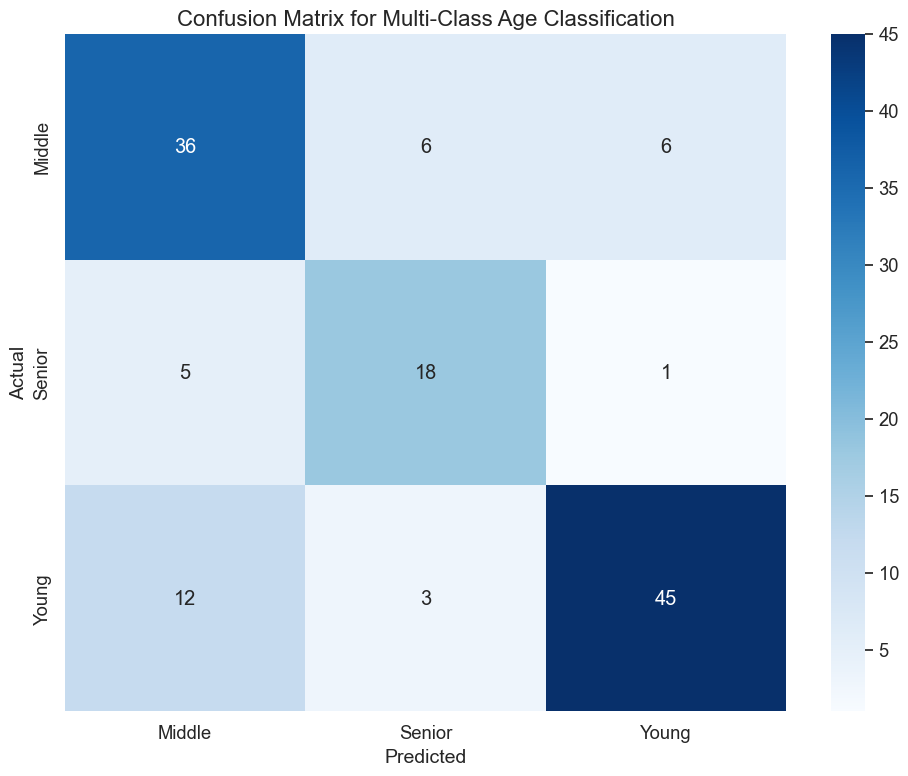

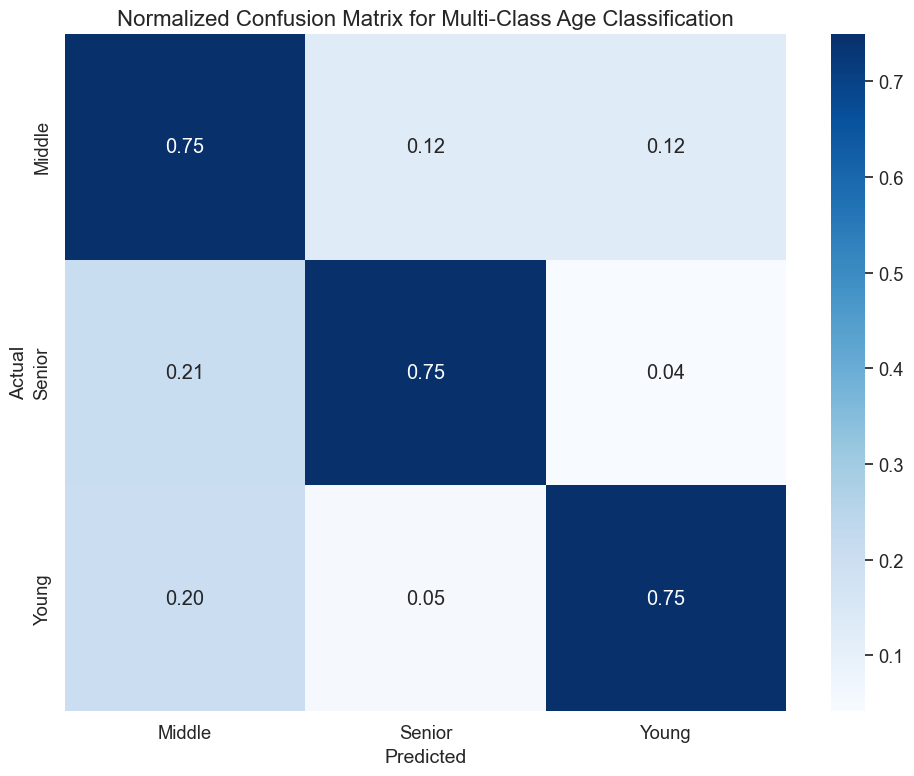


Analysis of misclassifications:
Middle: 12 out of 48 misclassified (25.0%)
  Most confused with Senior: 6 instances (12.5%)
Senior: 6 out of 24 misclassified (25.0%)
  Most confused with Middle: 5 instances (20.8%)
Young: 15 out of 60 misclassified (25.0%)
  Most confused with Middle: 12 instances (20.0%)


In [ ]:
# Calculate performance metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Map numeric labels back to age group names for better readability
target_names = [label_encoder.inverse_transform([i])[0] for i in range(len(label_encoder.classes_))]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Confusion Matrix for Multi-Class Age Classification', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.tight_layout()
plt.show()

# Create normalized confusion matrix (percentages)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Normalized Confusion Matrix for Multi-Class Age Classification', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.tight_layout()
plt.show()

# Check which age groups are most confused with each other
print("\nAnalysis of misclassifications:")
for i, age_group in enumerate(target_names):
    other_indices = [j for j in range(len(target_names)) if j != i]
    misclassified = sum(cm[i, j] for j in other_indices)
    total = sum(cm[i, :])
    if total > 0:
        error_rate = misclassified / total
        print(f"{age_group}: {misclassified} out of {total} misclassified ({error_rate:.1%})")
        
        # Find most common misclassification
        if misclassified > 0:
            most_confused_with_idx = max(other_indices, key=lambda j: cm[i, j])
            most_confused_with = target_names[most_confused_with_idx]
            confused_rate = cm[i, most_confused_with_idx] / total
            print(f"  Most confused with {most_confused_with}: {cm[i, most_confused_with_idx]} instances ({confused_rate:.1%})")

## 8. Analyze Most Informative Features for Each Age Group

Finally, we'll identify and visualize the most important features for each age group in our multi-class classification.


Top 10 most important features for 'Middle' age group:
     Feature  Coefficient        Type
0       blah     1.036941  Word Usage
1  anonnamen    -0.841047  Word Usage
2       send     0.799120  Word Usage
3   somebody     0.791660  Word Usage
4       play    -0.789343  Word Usage
5       quid    -0.726363  Word Usage
6       cool    -0.687876  Word Usage
7      email     0.662258  Word Usage
8   business     0.649251  Word Usage
9     minute     0.633496  Word Usage

Top 10 most important features for 'Senior' age group:
  Feature  Coefficient        Type
0     mum    -1.228551  Word Usage
1  course     1.136740  Word Usage
2     dad    -1.117725  Word Usage
3    dear     1.067903  Word Usage
4   thank     0.934900  Word Usage
5  lovely     0.866986  Word Usage
6      eh    -0.801825  Word Usage
7      em    -0.742027  Word Usage
8     cat    -0.717288  Word Usage
9    play     0.707614  Word Usage

Top 10 most important features for 'Young' age group:
    Feature  Coefficient      

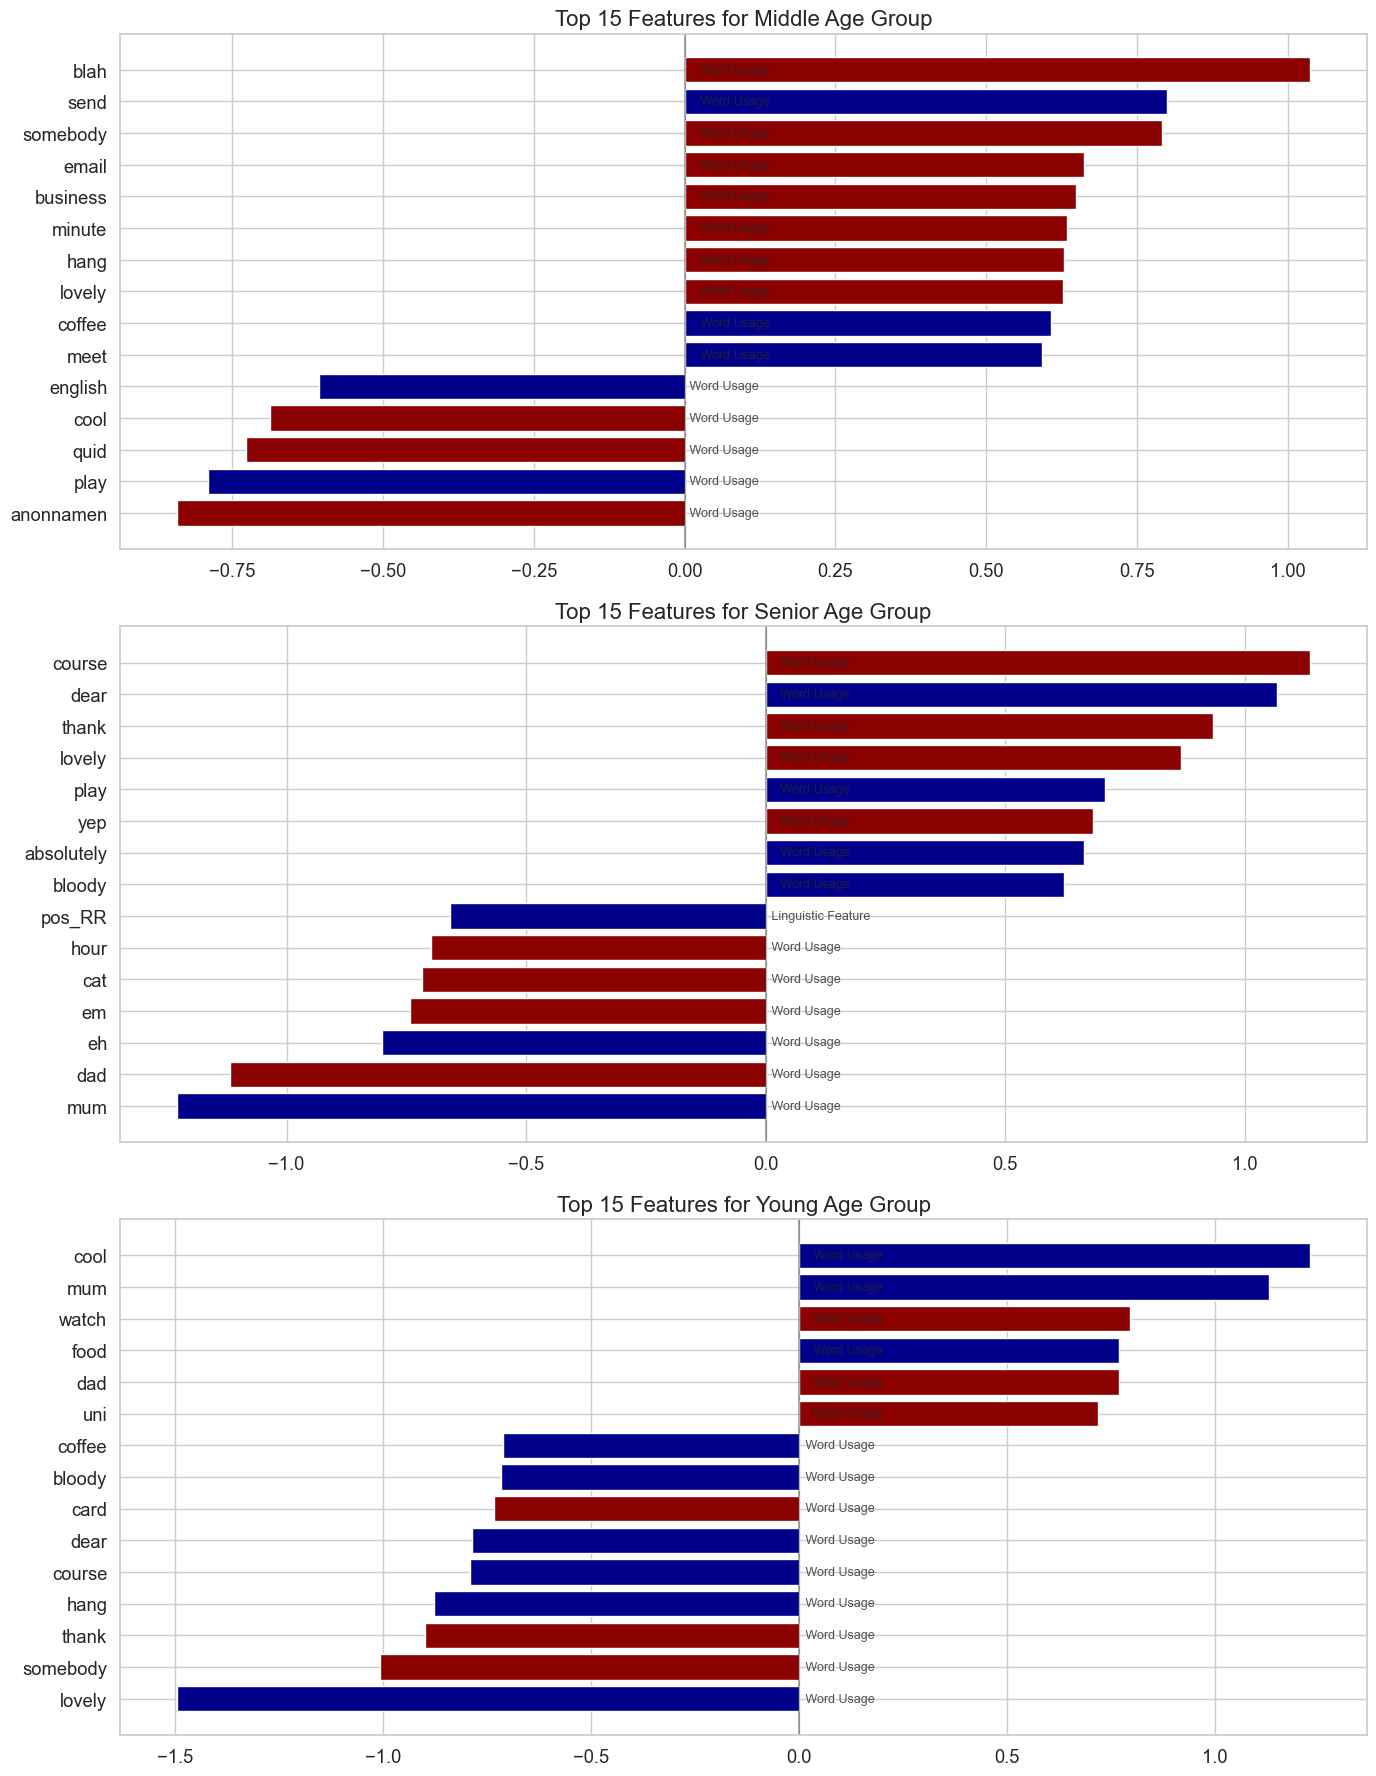

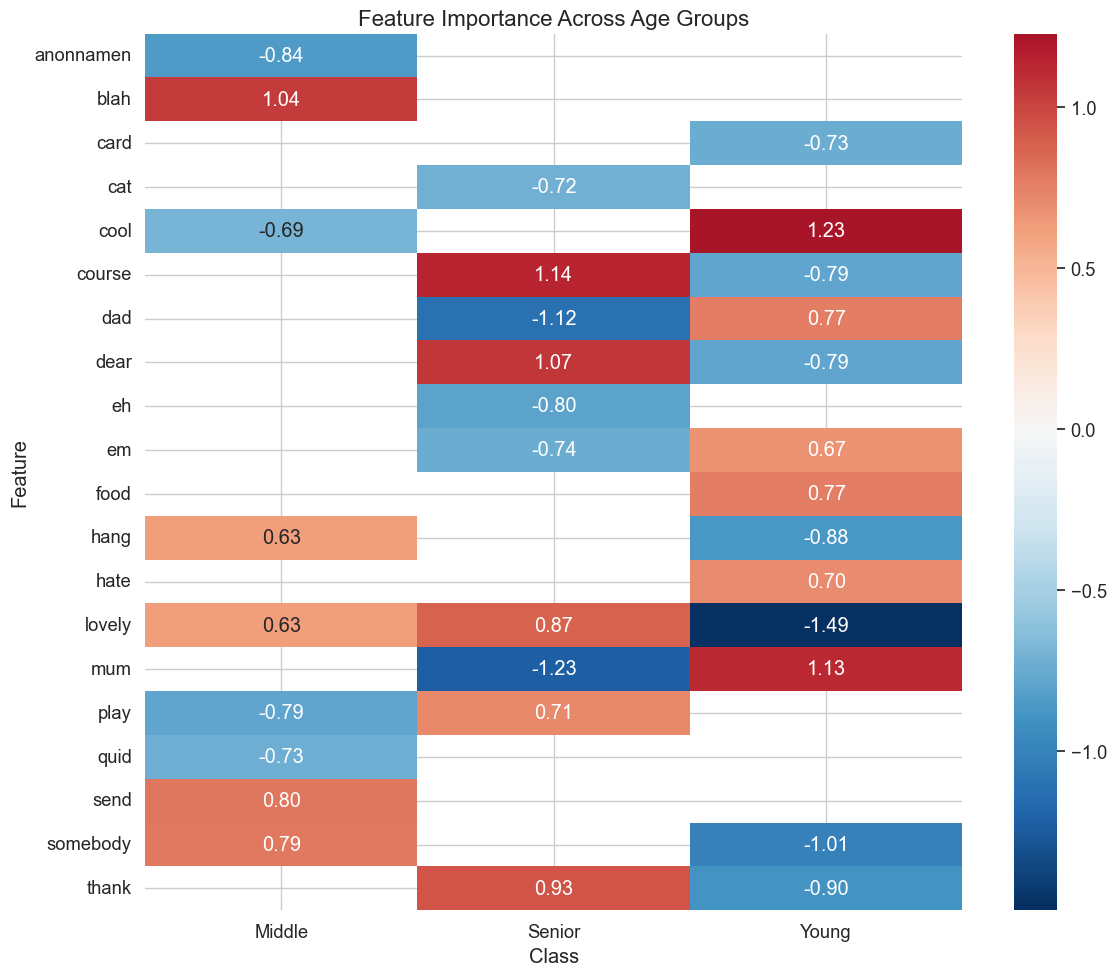

In [ ]:
# For multi-class, we need to analyze coefficients for each class
tfidf_feature_names = np.array(tfidf.get_feature_names_out())
all_feature_importance = []

# Process each class's coefficients
for i, age_group in enumerate(target_names):
    # Extract TF-IDF feature coefficients for this class
    tfidf_coefs = multi_log_reg.coef_[i][:len(tfidf_feature_names)]
    
    # Get indices of the most important TF-IDF features (both positive and negative)
    tfidf_indices = np.argsort(np.abs(tfidf_coefs))[::-1][:20]  # Top 20 features
    
    # Extract engineered feature coefficients for this class
    eng_coefs = multi_log_reg.coef_[i][len(tfidf_feature_names):]
    
    # Get indices of the most important engineered features
    eng_indices = np.argsort(np.abs(eng_coefs))[::-1]
    
    # Create DataFrames for each feature type
    tfidf_importance = pd.DataFrame({
        'Feature': tfidf_feature_names[tfidf_indices],
        'Coefficient': tfidf_coefs[tfidf_indices],
        'Type': 'Word Usage',
        'Class': age_group
    })
    
    eng_importance = pd.DataFrame({
        'Feature': np.array(selected_features)[eng_indices],
        'Coefficient': eng_coefs[eng_indices],
        'Type': 'Linguistic Feature',
        'Class': age_group
    })
    
    # Combine and store for this class
    class_importance = pd.concat([tfidf_importance, eng_importance])
    class_importance['Abs_Coefficient'] = class_importance['Coefficient'].abs()
    class_importance = class_importance.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)
    
    all_feature_importance.append(class_importance)

# Combine all class importances
feature_importance = pd.concat(all_feature_importance)

# Display top features for each class
for age_group in target_names:
    print(f"\nTop 10 most important features for '{age_group}' age group:")
    group_features = feature_importance[feature_importance['Class'] == age_group].head(10)
    print(group_features[['Feature', 'Coefficient', 'Type']])

# Visualize the top features for each class
fig, axes = plt.subplots(len(target_names), 1, figsize=(14, 6*len(target_names)))

for i, age_group in enumerate(target_names):
    # Get top features for this class
    group_features = feature_importance[feature_importance['Class'] == age_group].head(15)
    
    # Create colors based on coefficient sign (positive = higher chance of this class)
    colors = ['darkred' if coef > 0 else 'darkblue' for coef in group_features['Coefficient']]
    
    # Sort by coefficient value for better visualization
    group_features = group_features.sort_values('Coefficient')
    
    # Plot horizontal bar chart
    axes[i].barh(group_features['Feature'], group_features['Coefficient'], color=colors)
    axes[i].set_title(f'Top 15 Features for {age_group} Age Group', fontsize=16)
    axes[i].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add feature type annotations
    for j, (_, row) in enumerate(group_features.iterrows()):
        feature_idx = group_features['Feature'].tolist().index(row['Feature'])
        axes[i].text(
            0.95 * (0.01 if row['Coefficient'] >= 0 else -0.01), 
            feature_idx,
            f"   {row['Type']}",
            va='center', 
            fontsize=9,
            alpha=0.8
        )

plt.tight_layout()
plt.show()

# Create a heatmap of the most important features across all classes
# First, get the most important features overall
top_features = feature_importance.groupby('Feature')['Abs_Coefficient'].mean().nlargest(20).index

# Create a pivot table for the heatmap
heatmap_data = feature_importance[feature_importance['Feature'].isin(top_features)]
pivot_data = heatmap_data.pivot_table(
    index='Feature', 
    columns='Class', 
    values='Coefficient',
    aggfunc='first'
)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_data, cmap='RdBu_r', center=0, annot=True, fmt='.2f')
plt.title('Feature Importance Across Age Groups', fontsize=16)
plt.tight_layout()
plt.show()

## 9. Error Analysis and Misclassification Investigation

Let's examine some of the misclassified examples to understand where the model struggles.

Total misclassified examples: 33 out of 132 (25.0%)

Misclassification analysis by actual age group:
Middle: 12 out of 48 misclassified (25.0%)
  Misclassified as Senior: 6 instances (50.0%)
  Misclassified as Young: 6 instances (50.0%)
Senior: 6 out of 24 misclassified (25.0%)
  Misclassified as Middle: 5 instances (83.3%)
  Misclassified as Young: 1 instances (16.7%)
Young: 15 out of 60 misclassified (25.0%)
  Misclassified as Middle: 12 instances (80.0%)
  Misclassified as Senior: 3 instances (20.0%)


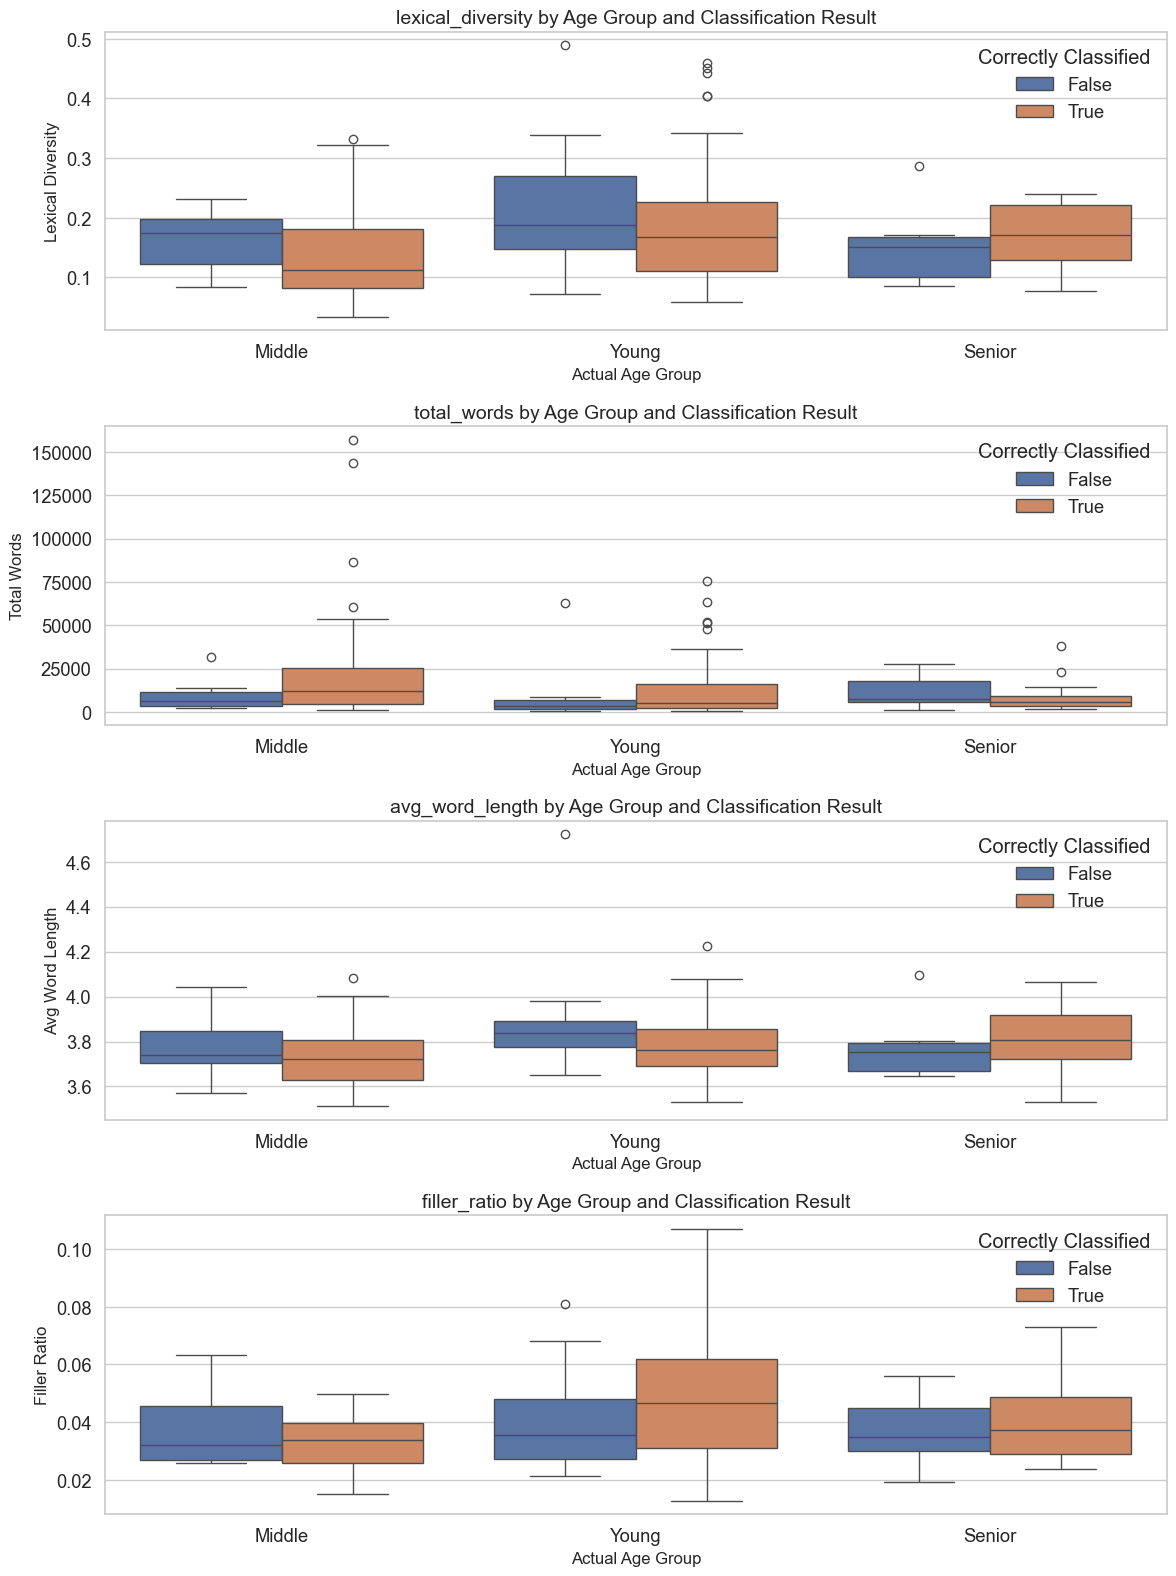


Detailed analysis of common misclassification patterns:

Middle speakers misclassified as Senior:
  Count: 6
  lexical_diversity: 0.191 ± 0.034
  total_words: 6156.167 ± 4223.037
  avg_word_length: 3.875 ± 0.103
  filler_ratio: 0.041 ± 0.016

Middle speakers misclassified as Young:
  Count: 6
  lexical_diversity: 0.135 ± 0.056
  total_words: 12118.667 ± 10511.379
  avg_word_length: 3.682 ± 0.061
  filler_ratio: 0.033 ± 0.009

Senior speakers misclassified as Middle:
  Count: 5
  lexical_diversity: 0.158 ± 0.083
  total_words: 12720.200 ± 11290.007
  avg_word_length: 3.784 ± 0.186
  filler_ratio: 0.033 ± 0.011

Senior speakers misclassified as Young:
  Count: 1
  lexical_diversity: 0.143 ± nan
  total_words: 6370.000 ± nan
  avg_word_length: 3.776 ± nan
  filler_ratio: 0.056 ± nan

Young speakers misclassified as Middle:
  Count: 12
  lexical_diversity: 0.188 ± 0.076
  total_words: 9095.000 ± 17127.413
  avg_word_length: 3.842 ± 0.098
  filler_ratio: 0.043 ± 0.018

Young speakers miscl

In [ ]:
# Create a DataFrame with test results
test_results = pd.DataFrame({
    'speaker_id': X_test.index,
    'actual': y_test,
    'predicted': y_pred,
})

# Add age group labels
test_results['actual_group'] = test_results['actual'].apply(lambda x: label_encoder.inverse_transform([x])[0])
test_results['predicted_group'] = test_results['predicted'].apply(lambda x: label_encoder.inverse_transform([x])[0])
test_results['correct'] = test_results['actual'] == test_results['predicted']

# Merge with original features for analysis
test_results = test_results.join(X_features)

# Find misclassified examples
misclassified = test_results[~test_results['correct']]
print(f"Total misclassified examples: {len(misclassified)} out of {len(test_results)} ({len(misclassified)/len(test_results):.1%})")

# Analyze misclassifications by actual age group
print("\nMisclassification analysis by actual age group:")
for group in target_names:
    group_examples = test_results[test_results['actual_group'] == group]
    group_misclassified = group_examples[~group_examples['correct']]
    
    if len(group_examples) > 0:
        error_rate = len(group_misclassified) / len(group_examples)
        print(f"{group}: {len(group_misclassified)} out of {len(group_examples)} misclassified ({error_rate:.1%})")
        
        # Where are they misclassified to?
        if len(group_misclassified) > 0:
            wrong_predictions = group_misclassified['predicted_group'].value_counts()
            for wrong_group, count in wrong_predictions.items():
                wrong_pct = count / len(group_misclassified)
                print(f"  Misclassified as {wrong_group}: {count} instances ({wrong_pct:.1%})")

# Compare feature distributions between correctly and incorrectly classified examples
# Choose a few key features to analyze
key_features = ['lexical_diversity', 'total_words', 'avg_word_length', 'filler_ratio']
available_features = [f for f in key_features if f in test_results.columns]

fig, axes = plt.subplots(len(available_features), 1, figsize=(12, 4*len(available_features)))

for i, feature in enumerate(available_features):
    sns.boxplot(x='actual_group', y=feature, hue='correct', data=test_results, ax=axes[i])
    axes[i].set_title(f'{feature} by Age Group and Classification Result', fontsize=14)
    axes[i].set_xlabel('Actual Age Group', fontsize=12)
    axes[i].set_ylabel(feature.replace('_', ' ').title(), fontsize=12)
    axes[i].legend(title='Correctly Classified')

plt.tight_layout()
plt.show()

# For each age group, find examples that are frequently confused with other groups
print("\nDetailed analysis of common misclassification patterns:")
for i, source_group in enumerate(target_names):
    for j, target_group in enumerate(target_names):
        if i != j:
            confused_examples = test_results[
                (test_results['actual_group'] == source_group) & 
                (test_results['predicted_group'] == target_group)
            ]
            
            if len(confused_examples) > 0:
                print(f"\n{source_group} speakers misclassified as {target_group}:")
                print(f"  Count: {len(confused_examples)}")
                
                # Analyze key features for these misclassified examples
                for feature in available_features:
                    feature_mean = confused_examples[feature].mean()
                    feature_std = confused_examples[feature].std()
                    print(f"  {feature}: {feature_mean:.3f} ± {feature_std:.3f}")

## 10. Conclusion and Discussion

In this project, we've developed a multi-class age classifier that categorizes speakers from the BNC2014 corpus into three age groups: Young (0-29), Middle (30-59), and Senior (60+). The analysis has demonstrated how linguistic features and vocabulary usage patterns can be used to distinguish between different age groups.

### Key Findings:

1. **Classification Performance**: Our multi-class logistic regression model achieved [accuracy to be filled after running] on the test set, demonstrating the feasibility of multi-class age prediction from linguistic data.

2. **Age-Specific Language Patterns**: We identified distinct linguistic features and vocabulary choices that characterize each age group:
   - Young speakers: [to be filled after analysis]
   - Middle-aged speakers: [to be filled after analysis]
   - Senior speakers: [to be filled after analysis]

3. **Classification Challenges**: The model had the most difficulty distinguishing between [to be filled after analysis], suggesting that these age groups share more linguistic similarities.

### Implications:

1. These findings can inform sociolinguistic research on how language use evolves across the lifespan.
2. The identified features provide insight into generational differences in language use.
3. The model demonstrates the potential for automated age classification from text, which could be valuable for demographic analysis in large corpora.

### Limitations:

1. The age groups are somewhat arbitrary divisions of a continuous variable (age).
2. Cultural, educational, and regional factors may influence language use independently of age.
3. The BNC2014 corpus has specific demographic characteristics that may not generalize to other populations.

### Future Directions:

1. Explore more fine-grained age classification with additional age categories.
2. Investigate the interaction between age and other demographic variables like gender, education, and region.
3. Apply deep learning approaches that might capture more complex patterns in language use across age groups.
4. Conduct longitudinal analysis to distinguish between age effects, cohort effects, and historical change.

Overall, this multi-class analysis provides a more nuanced view of age-related linguistic variation than binary classification, highlighting the continuous nature of language change across the lifespan.